In [9]:
import numpy as np
import torch
import sys
from utils_old import *
import utils
from matplotlib import pyplot as plt
import torch.nn as nn
import time
from numba import cuda
from tqdm import tqdm, trange
import os
import pyroc
import pandas as pd
import gc
from IPython.display import clear_output
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"  
device = torch.device("cuda:0")
dtype = torch.float32
torch.manual_seed(42)
np.random.seed(42)

In [10]:

H = 500
out= 100
L = 1
class DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, out, bias=True),
        )
    def forward(self, input):
        output = self.model(input)
        return output

class another_DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(another_DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, 28, bias=True),
        )
    def forward(self, input):
        output = self.model(input) + input
        return output

class Classifier(torch.nn.Module):
    def __init__(self, H=300, layers = 5):
        super(Classifier, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, 1, bias=True),
            torch.nn.Sigmoid(),
        )
        if layers == 6:
            self.model = torch.nn.Sequential(
                torch.nn.Linear(28, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, 1, bias=True),
                torch.nn.Sigmoid(),
            )
    def forward(self, input):
        output = self.model(input)
        return output

In [11]:
dataset = np.load('HIGGS.npy')
dataset_P = dataset[dataset[:,0]==0][:, 1:] # background (5829122, 28)
dataset_Q = dataset[dataset[:,0]==1][:, 1:] # signal     (5170877, 28)
del dataset

In [12]:
# 看(n_eval,m)
# 选定 X_eval, Y_eval, 还要算phi=Eq[k(y,z)]-Ep[k(x,z)]的threhold在哪里
# 必须手算!
def generate_PQ(n_eval, Samples, batch_size = 5000, If_n_large_MonteCarlo = 1000):
    X_eval = dataset_P[np.random.choice(dataset_P.shape[0], n_eval, replace=False)]
    Y_eval = dataset_Q[np.random.choice(dataset_Q.shape[0], n_eval, replace=False)]
    EKxx, EKyy, EKxy = compute_gamma(X_eval, Y_eval, model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst, MonteCarlo=If_n_large_MonteCarlo)
    # 算定下来X_eval, Y_eval之后phi的真实的分布
    batches = (Samples-1)//batch_size + 1
    P_scores = np.zeros(Samples)
    Q_scores = np.zeros(Samples)
    for i in trange(batches):
        remain = batch_size
        if i==batches-1:
            remain = Samples - batch_size*(batches-1)
        S_hand = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], remain, replace=False)],
                    dataset_Q[np.random.choice(dataset_Q.shape[0], remain, replace=False)]), axis=0)
        S_hand = MatConvert(S_hand, device, dtype)
        PQhat_hand = compute_score_func(S_hand, X_eval, Y_eval, 
                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                    M = n_eval)
        PQhat_hand = PQhat_hand.cpu().detach().numpy()
        P_scores[i*batch_size: i*batch_size+remain] = PQhat_hand[:remain]
        Q_scores[i*batch_size: i*batch_size+remain] = PQhat_hand[remain:]
    return X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy


In [13]:
# 注意P_scores, Q_scores已经考虑到n_eval贡献的方差
# EKxx, EKyy, EKxy完全是n_eval决定
class PQ_data():
    def __init__(self, P_scores, Q_scores, EKxx, EKyy, EKxy):
        self.P_scores = P_scores
        self.Q_scores = Q_scores
        self.P_mean = np.mean(P_scores)
        self.P_std = np.std(P_scores)
        self.Q_mean = np.mean(Q_scores)
        self.Q_std = np.std(Q_scores)
        self.EKxx = EKxx
        self.EKyy = EKyy
        self.EKxy = EKxy
    def pval_T_m_in_sigma(self, pi, m, use_gaussian, MonteCarlo):
        T = pi*self.Q_mean + (1-pi)*self.P_mean
        # use_gaussian: 是否用高斯近似, 0是用MonteCarlo近似，1是用高斯近似
        P_scores = self.P_scores
        mean = self.P_mean
        std = self.P_std
        if m==1:
            p = np.mean(P_scores > T)
            p = -scipy.stats.norm.ppf(p)
        if use_gaussian:
            p = (T-mean)/std*np.sqrt(m)
        else:
            T_mix_MonteCarlo_list = np.zeros(MonteCarlo)
            for i in range(MonteCarlo):
                idx = np.random.choice(P_scores.shape[0], m, replace=False)
                T_mix_MonteCarlo_list[i] = np.mean(P_scores[idx])
            p = np.mean(T_mix_MonteCarlo_list > T)
            p = -scipy.stats.norm.ppf(p)
        self.p = p
        return p
    def type_1_error_H0(self, pi, m, use_gaussian, MonteCarlo):
        P_scores = self.P_scores
        Q_scores = self.Q_scores
        mean = self.P_mean
        std = self.P_std
        P_mean = self.P_mean
        P_std = self.P_std
        Q_mean = self.Q_mean
        gamma = self.EKxx*(pi/2-1) + self.EKxy*(1-pi) + self.EKyy*(pi/2)
        #gamma = (pi/2)*Q_mean + (1-pi/2)*P_mean
        self.gamma = gamma
        if m==1:
            type_1_error = np.mean(P_scores > gamma)
        if use_gaussian:
            type_1_error = 1-scipy.stats.norm.cdf((gamma-mean)/std*np.sqrt(m))
        else:
            MonteCarlo_list = np.zeros(MonteCarlo)
            for i in range(MonteCarlo):
                idx = np.random.choice(P_scores.shape[0], m, replace=False)
                MonteCarlo_list[i] = np.mean(P_scores[idx])
            type_1_error = np.mean(MonteCarlo_list > gamma)
        self.type_1_error = type_1_error
        return type_1_error
    def type_2_error_H1(self, pi, m, use_gaussian, MonteCarlo):
        P_scores = self.P_scores
        Q_scores = self.Q_scores
        P_mean = self.P_mean
        P_std = self.P_std
        Q_mean = self.Q_mean
        Q_std = self.Q_std
        gamma = self.EKxx*(pi/2-1) + self.EKxy*(1-pi) + self.EKyy*(pi/2)
        #gamma = (pi/2)*Q_mean + (1-pi/2)*P_mean
        self.gamma = gamma
        if m==1:
            type_2_error = np.mean(Q_scores < gamma)
        if use_gaussian:
            mean = Q_mean*pi + P_mean*(1-pi)
            std = np.sqrt(pi*Q_std**2 + (1-pi)*P_std**2 + pi*(1-pi)*(P_mean-Q_mean)**2)
            type_2_error = scipy.stats.norm.cdf((gamma-mean)/std*np.sqrt(m))
        else:
            MonteCarlo_list = np.zeros(MonteCarlo)
            for i in range(MonteCarlo):
                Signals_idx = np.random.choice(Q_scores.shape[0], int(m*pi), replace=False)
                Backgrounds_idx = np.random.choice(P_scores.shape[0], int(m*(1-pi)), replace=False)
                MonteCarlo_list[i] = np.mean(np.concatenate((Q_scores[Signals_idx], P_scores[Backgrounds_idx])))
            type_2_error = np.mean(MonteCarlo_list < gamma)
        self.type_2_error = type_2_error
        return type_2_error

In [14]:
torch.cuda.empty_cache()
gc.collect()

1151

# 直觉

In [15]:
# n_train = 1600101
# path ='./checkpoint1600101/25/'
# path ='./Mix/checkpoint3000/0/'

# model = DN(300, 100).cuda()
# another_model = another_DN(300, 100).cuda()
# model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)

In [16]:
# n_eval = 4
# Samples = 100000
# X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy = generate_PQ(n_eval, Samples=10000, batch_size=10000, If_n_large_MonteCarlo = 10)
# plt.hist(P_scores, bins=100, alpha=0.5, label='P(Background)', color='r')
# plt.hist(Q_scores, bins=100, alpha=0.5, label='Q(Signal)', color='b')
# My_class = PQ_data(P_scores, Q_scores, EKxx, EKyy, EKxy)
# m = 100
# pi = 0.1
# Pval = My_class.pval_T_m_in_sigma(pi, m, use_gaussian=1, MonteCarlo=0)
# Type1 = My_class.type_1_error_H0(pi, m, use_gaussian=1, MonteCarlo=0)
# Type2 = My_class.type_2_error_H1(pi, m, use_gaussian=1, MonteCarlo=0)
# plt.axvline(My_class.gamma, color='g', label='threshold $\gamma$')
# plt.axvline(My_class.P_mean, color='r', label='P mean')
# plt.axvline(My_class.Q_mean, color='b', label='Q mean')
# title1 = '$n_{train}=1.3e6, n_{eval}=%d$'%n_eval
# title2 = 'm=%d, $\pi=%.2f$'%(m, pi)
# title3 = 'Pval= %.3f, type1 error= %.3f, type2 error= %.3f'%(Pval, Type1, Type2)
# plt.title(title1+'\n'+title2+'\n'+title3)
# Mix_scores = np.concatenate((P_scores[0:int(Samples*(1-pi))], Q_scores[0:int(Samples*pi)]))
# plt.hist(Mix_scores, bins=100, alpha=0.5, label='Mixed distribution', color='y')
# Mix_mean = np.mean(Mix_scores)
# plt.axvline(Mix_mean, color='y', label='Mixed mean')
# plt.legend()

# 固定pi=0.1, Gaussian
所以对每一组(n,m,pi)有三个(p-val, typeI, typeII)  
pval = pval(平均H1) = 平均H1后面的尾  
type-I = gamma后面  

In [17]:
pi= 0.1

n_list = 10**np.linspace(1, 4, 30)
n_list = n_list.astype(int)
m_list = 10**np.linspace(1, 4, 30)
m_list = m_list.astype(int)

repeat_sample_n_eval = 10
Pval_mat = np.zeros((len(n_list), len(m_list), repeat_sample_n_eval))
Type1_mat = np.zeros((len(n_list), len(m_list), repeat_sample_n_eval))
Type2_mat = np.zeros((len(n_list), len(m_list), repeat_sample_n_eval))
Use_Gaussian = 1

In [18]:
# for r in range(repeat_sample_n_eval):
#     print(r)
#     for i in trange(len(n_list)):
#         print(i)
#         with torch.no_grad():
#             torch.cuda.empty_cache()
#             n_eval = n_list[i]
#             X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy = generate_PQ(n_eval, Samples=20000, batch_size=5000, 
#                                                                     If_n_large_MonteCarlo=10)
#             My_class = PQ_data(P_scores, Q_scores, EKxx, EKyy, EKxy)
#             for j in range(len(m_list)):
#                 m = m_list[j]
#                 #Pval_mat[i,j,r] = My_class.pval_T_m_in_sigma(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=0)
#                 Type1_mat[i,j,r] = My_class.type_1_error_H0(pi, m, use_gaussian=True, MonteCarlo=1000)
#                 Type2_mat[i,j,r] = My_class.type_2_error_H1(pi, m, use_gaussian=True, MonteCarlo=1000)
#             del My_class, X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy
#             gc.collect()
#     clear_output()

In [19]:
# Pval_mat = np.load('Pval_mat.npy')
#Pval_mat = np.mean(Pval_mat[:,:,0:2], axis=2)
Type1_mat = np.mean(Type1_mat[:,:,0:2], axis=2)
Type2_mat = np.mean(Type2_mat[:,:,0:2], axis=2)


In [21]:
# ns = np.array([1300000, 1000000, 700000, 400000, 200000, 100000, 50000, 30000, 10000, 6000, 3000])
# ms = 10**np.linspace(1, 4, 30)
# ms = ms.astype(int)
# P_m_ntr  = np.zeros((len(ns), len(ms)))
# Error_m_ntr = np.zeros((len(ns), len(ms)))
# repeats = 10
# for k in range(repeats):
#     for i,n in enumerate(ns):
#         path = './Mix/checkpoint%d/0/'%(n+1)
#         model = DN(300, 100).cuda()
#         another_model = DN(300, 100).cuda()
#         model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)

#         n_train = n
#         n_eval = 20000
#         n_test = 20000
#         idx = np.random.choice(dataset_P.shape[0]-n_train, n_test+n_eval, replace=False) + n_train
#         idy = np.random.choice(dataset_Q.shape[0]-n_train, n_test+n_eval, replace=False) + n_train
#         X_eval = dataset_P[idx][0:n_eval]
#         Y_eval = dataset_Q[idy][0:n_eval]
#         X_test = dataset_P[idx][n_eval:n_eval+n_test]
#         Y_test = dataset_Q[idy][n_eval:n_eval+n_test]
#         X_eval = MatConvert(X_eval, device=device, dtype=dtype)
#         Y_eval = MatConvert(Y_eval, device=device, dtype=dtype)
#         X_test = MatConvert(X_test, device=device, dtype=dtype)
#         Y_test = MatConvert(Y_test, device=device, dtype=dtype)
#         X_eval_test = X_eval
#         Y_eval_test = Y_eval

#         p_soft = utils.get_pval_at_once(X_eval, Y_eval, X_eval_test, Y_eval_test, X_test, Y_test,
#                             model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst,
#                             batch_size = 5000,
#                             norm_or_binom=True)
        
#         batch_size = 10000
#         Samples = 20000
#         If_n_large_MonteCarlo = 10
#         X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy = generate_PQ(n_eval, Samples=20000, batch_size=5000, 
#                                                                         If_n_large_MonteCarlo=10)
#         My_class  = PQ_data(P_scores, Q_scores, EKxx, EKyy, EKxy)
#         clear_output()
#         for j in range(len(ms)):
#             m = m_list[j]
#             P_m_ntr[i,j] += p_soft*11/np.sqrt(1100) * pi * np.sqrt(m)
#             Error_m_ntr[i,j] += My_class.type_1_error_H0(pi, m, use_gaussian=True, MonteCarlo=0) + My_class.type_2_error_H1(pi, m, use_gaussian=True, MonteCarlo=0)

# P_m_ntr = P_m_ntr/repeats
# Error_m_ntr = Error_m_ntr/repeats

In [22]:
# np.save('P_m_ntr.npy', P_m_ntr)
# np.save('Error_m_ntr.npy', Error_m_ntr)

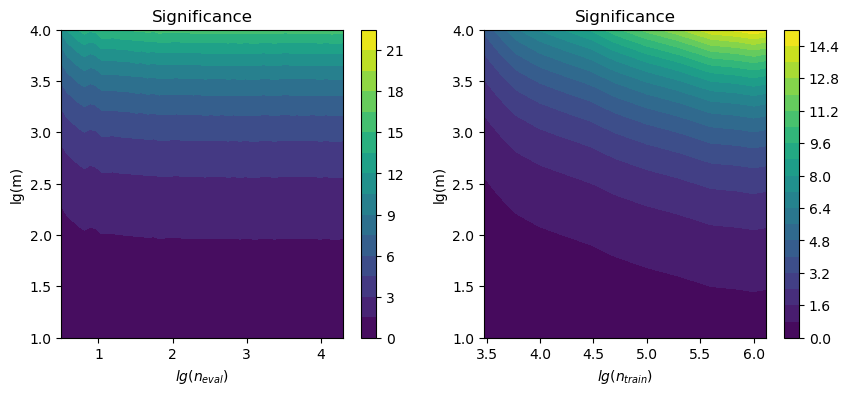

In [23]:
Pval_mat = np.load('Pval_mat.npy')
n_list_P_mat = 10**np.linspace(0.5, 4.3, 50)
m_list_P_mat = 10**np.linspace(0, 4.3, 50)
fig = plt.figure(figsize=(10,4))



plt.subplot(1,2,1)
plt.contourf(np.log10(n_list_P_mat), np.log10(m_list_P_mat), Pval_mat.T, levels=20)
plt.colorbar()
plt.xlabel('$lg(n_{eval})$')
plt.ylabel('lg(m)')
plt.title('Significance')
plt.ylim(1, 4)

# n_list = 10**np.linspace(0.5, 4.3, 40)
# n_list = n_list.astype(int)
# m_list = 10**np.linspace(0.5, 4.3, 40)
# m_list = m_list.astype(int)
# Type12_mat = np.load('type12.npy')
# plt.subplot(1,4,2)
# plt.contourf(np.log10(n_list), np.log10(m_list), Type12_mat.T, levels=20)
# plt.colorbar()
# plt.xlabel('$lg(n_{eval})$')
# plt.ylabel('lg(m)')
# plt.title('Type I error + II error')

ns = np.array([1300000, 1000000, 700000, 400000, 200000, 100000, 50000, 30000, 10000, 6000, 3000])
ms = 10**np.linspace(1, 4, 30)
ms = ms.astype(int)
P_m_ntr = np.load('P_m_ntr.npy')
Error_m_ntr = np.load('Error_m_ntr.npy')
plt.subplot(1,2,2)
im = plt.contourf(np.log10(ns), np.log10(ms), P_m_ntr.T, levels=20)
plt.colorbar()
plt.xlabel('$lg(n_{train})$')
plt.ylabel('lg(m)')
plt.title('Significance')


# plt.subplot(1,4,4)
# plt.contourf(np.log10(ns), np.log10(ms), Error_m_ntr.T, levels=20)
# plt.colorbar()
# plt.xlabel('$lg(n_{train})$')
# plt.ylabel('lg(m)')
# plt.title('Type I error + Type II error')

#plt.suptitle(r'Fix kernel ($n_{train}=1.3e6$), Use Gaussian Approx='+str(Use_Gaussian)+', $\pi$='+str(pi))
#fig.colorbar(im)
plt.savefig('./paper/tradeoff_p.pdf')

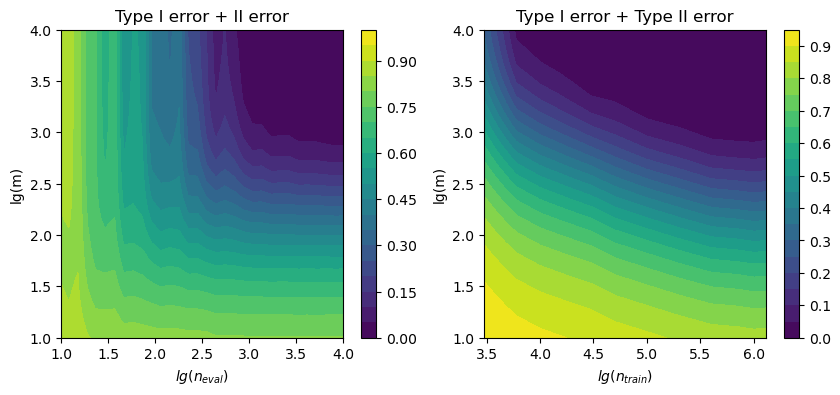

In [28]:
Pval_mat = np.load('Pval_mat.npy')
n_list_P_mat = 10**np.linspace(0.5, 4.3, 50)
m_list_P_mat = 10**np.linspace(0, 4.3, 50)
fig = plt.figure(figsize=(10,4))

n_list = 10**np.linspace(0.5, 4.3, 40)
n_list = n_list.astype(int)
m_list = 10**np.linspace(0.5, 4.3, 40)
m_list = m_list.astype(int)
Type12_mat_old = np.load('type12.npy')
Type12_mat_medi = np.load('Type1_mat_new_new.npy') + np.load('Type2_mat_new_new.npy')
Type12_mat_new = np.load('Type1_mat_new_new_new_new.npy') + np.load('Type2_mat_new_new_new_new.npy')
Type12_mat_medi = np.mean(Type12_mat_medi[:,:,0:36], axis=2)
Type12_mat_new = np.mean(Type12_mat_new[:,:,0:36], axis=2)
Type12_mat = (Type12_mat_old + Type12_mat_medi + Type12_mat_new)/3
plt.subplot(1,2,1)
plt.contourf(np.log10(n_list), np.log10(m_list), Type12_mat.T, levels=20)
plt.colorbar()
plt.xlabel('$lg(n_{eval})$')
plt.ylabel('lg(m)')
plt.title('Type I error + II error')
plt.xlim(1, 4)
plt.ylim(1, 4)


plt.subplot(1,2,2)
plt.contourf(np.log10(ns), np.log10(ms), Error_m_ntr.T, levels=20)
plt.colorbar()
plt.xlabel('$lg(n_{train})$')
plt.ylabel('lg(m)')
plt.title('Type I error + Type II error')

#plt.suptitle(r'Fix kernel ($n_{train}=1.3e6$), Use Gaussian Approx='+str(Use_Gaussian)+', $\pi$='+str(pi))
fig.colorbar(im)
plt.savefig('./paper/tradeoff_type.pdf')

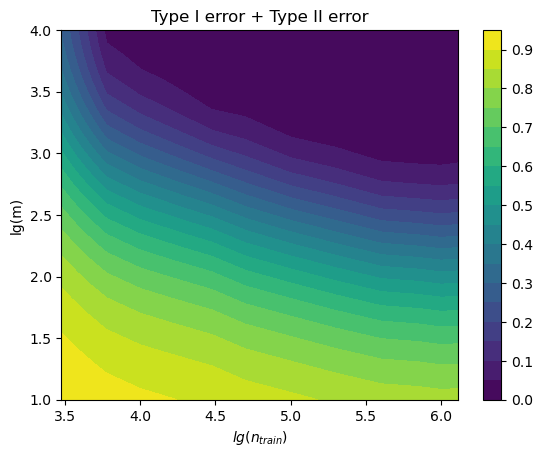

In [25]:
plt.contourf(np.log10(ns), np.log10(ms), Error_m_ntr.T, levels=20)
plt.colorbar()
plt.xlabel('$lg(n_{train})$')
plt.ylabel('lg(m)')
plt.title('Type I error + Type II error')
plt.savefig('./paper/tradeoff-m-train.pdf')


In [26]:
# np.save('Pval_mat.npy', Pval_mat)
# np.save('Type1_mat.npy', Type1_mat)
# np.save('Type2_mat.npy', Type2_mat)
Pval_mat = np.load('Pval_mat.npy')
Type1_mat = np.load('Type1_mat.npy')
Type2_mat = np.load('Type2_mat.npy')

In [27]:
Type1_mat.shape

(50, 50)